# Sentiment Analysis
## Data Formatting and Model Training
---

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from sklearn.model_selection import train_test_split
import h5py

import io
import json
import time

In [2]:
# Loading data
# data = pd.read_csv("../input/sentimentanalysisprojectdata/ProcesseData.csv")
data = pd.read_csv("./ProcessedData.csv")

data = data.drop(columns=["Unnamed: 0"])
X = list(data.tweet) # X => Sentence
Y = list(data.label) # Y => Sentiment

---
### Splitting Data into Train and Test sets

In [3]:
# 0 -> Negative, 1 -> Positive
Y = [1 if i!=0 else i for i in Y]

In [4]:
# 33% data will be used for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

---
## Tokenizing, Sequencing and Padding

### 01 Tokenizing
Tokenizing is the mapping of words to numbers. 

`Tokenizer()` in tensorflow generates a dictionary of keys as words and its values are unique numbers

`tokenizer.word_index` stores the generated dictionary

**This will be done only on train set**

In [5]:
vocab_size = 30000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
%time tokenizer.fit_on_texts(X_train)

CPU times: user 22.3 s, sys: 66.4 ms, total: 22.4 s
Wall time: 22.4 s


In [6]:
word_index = tokenizer.word_index

### Save the tokenizer as ot will be used for prediction

In [7]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Load tokenizer
<pre>
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
</pre>

### 02 Sequencing and Padding

`Tokenizer()` object can be used to convert strings to numbers once it is fit corpus of text

`tokenizer.texts_to_sequences()` method will map words to its currosponding int value from word_index

Padding is used to convert all tokenized strings to the same length so that ML Models can use it as input

**Sequencing and Padding Train Data**

In [8]:
train_seq = tokenizer.texts_to_sequences(X_train)
train_padSeq = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type) # padSeq can be used as input to train a mode

**Sqeuencing and Padding Test Data**

In [9]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padSeq = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type) # padSeq can be used as input to train a mode

---
## NeutalNet

1st layer is an Embedding layer where direction of each word will be learned per epoc

Pooling is done using `GlobalAveragePoling1D()`

Dense layer is the Deep Neural Network, in which 1st layer have an Activation of `relu` or Rectify Linear which is a Linear activationn layer

The 2nd dense layer is a `sigmoid` activation function

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
# Converting data to np array
train_padSeq = np.array(train_padSeq)
test_padSeq = np.array(test_padSeq)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [12]:
n_epochs = 30

# Training the model with 20 epochs
# (used to gain insignt on model training) verbose =  0 => silent  /  1 => progress bar  /  2 => one line per epoch
history = model.fit(train_padSeq, Y_train, epochs = n_epochs, validation_data = (test_padSeq, Y_test), verbose = 1)

Epoch 1/30
33500/33500 [==============================] - 128s 4ms/step - loss: 0.4663 - accuracy: 0.7825 - val_loss: 0.4323 - val_accuracy: 0.8005
Epoch 2/30
33500/33500 [==============================] - 130s 4ms/step - loss: 0.4266 - accuracy: 0.8035 - val_loss: 0.4255 - val_accuracy: 0.8038
Epoch 3/30
33500/33500 [==============================] - 127s 4ms/step - loss: 0.4183 - accuracy: 0.8079 - val_loss: 0.4235 - val_accuracy: 0.8061
Epoch 4/30
33500/33500 [==============================] - 127s 4ms/step - loss: 0.4122 - accuracy: 0.8116 - val_loss: 0.4219 - val_accuracy: 0.8076
Epoch 5/30
33500/33500 [==============================] - 129s 4ms/step - loss: 0.4076 - accuracy: 0.8146 - val_loss: 0.4232 - val_accuracy: 0.8080
Epoch 6/30
33500/33500 [==============================] - 128s 4ms/step - loss: 0.4034 - accuracy: 0.8172 - val_loss: 0.4217 - val_accuracy: 0.8085
Epoch 7/30
33500/33500 [==============================] - 128s 4ms/step - loss: 0.3998 - accuracy: 0.8191 - val_

In [13]:
#save the model after training
model.save("SentimentModel01.h5")

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           480000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 480,433
Trainable params: 480,433
Non-trainable params: 0
_________________________________________________________________


### Evaluating the model

In [15]:
test_loss, test_acc = model.evaluate(test_padSeq, Y_test, verbose=0)
print(f"test accuracy {test_acc*100}")
print(f"test loss {test_loss*100}")

train_loss, train_acc = model.evaluate(train_padSeq, Y_train, verbose=0)

print(f"train accuracy {train_acc*100}")
print(f"train loss {train_loss*100}")

test accuracy 79.83920574188232
test loss 46.279966831207275
train accuracy 85.24841666221619
train loss 33.66129994392395


### Make Predictions

In [16]:
# loadMode = tf.keras.models.load_model('<MODEL NAME>')

In [17]:
# Load tokenizer and model before making to use the model

# Load Tokenizer
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

model = tf.keras.models.load_model("./SentimentModel01.h5")

In [18]:
def predictSentiment(x):
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return model.predict(padded)

In [19]:
predictSentiment(["Hi there, how are you", "if you dont have errors while importing h5py you are good to save"])

array([[0.99324006],
       [0.67132217]], dtype=float32)

In [21]:
import matplotlib.pyplot as plt

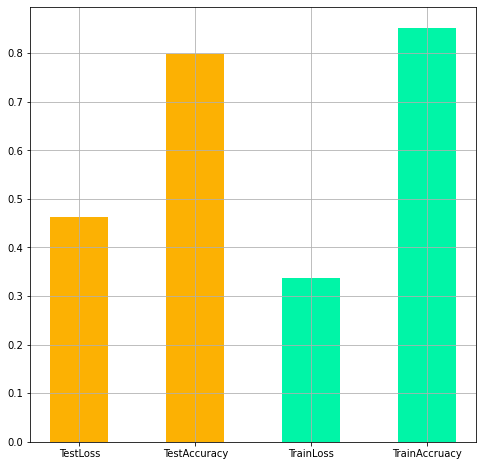

In [39]:
plt.figure(figsize=(8,8))
plt.bar(["TestLoss", "TestAccuracy", "TrainLoss", "TrainAccruacy"],
        [test_loss, test_acc, train_loss, train_acc],
        width=0.5,
        color=["#fcb103", "#fcb103", "#00f5a7", "#00f5a7"])
plt.grid()
plt.show()